# Hyperparameter tuning by grid-search

In the previous notebook, we saw that hyperparameters can affect the
generalization performance of a model. In this notebook, we show how to
optimize hyperparameters using a grid-search approach.

## Our predictive model

Let us reload the dataset as we did previously:

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")

We extract the column containing the target.

In [2]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information from the `"education"` column.

In [3]:
data = adult_census.drop(columns=[target_name, "education-num"])
data

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
48838,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
48839,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
48840,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


Once the dataset is loaded, we split it into a training and testing sets.

In [5]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

We define a pipeline as seen in the first module, to handle both numerical and
categorical features.

The first step is to select all the categorical columns.

In [6]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Here we use a tree-based model as a classifier (i.e.
`HistGradientBoostingClassifier`). That means:

* Numerical variables don't need scaling;
* Categorical variables can be dealt with an `OrdinalEncoder` even if the
  coding order is not meaningful;
* For tree-based models, the `OrdinalEncoder` avoids having high-dimensional
  representations.

We now build our `OrdinalEncoder` by passing it the known categories.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

We then use a `ColumnTransformer` to select the categorical columns and apply
the `OrdinalEncoder` to them.

In [8]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

Finally, we use a tree-based classifier (i.e. histogram gradient-boosting) to
predict whether or not a person earns more than 50 k$ a year.

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a grid-search

In the previous exercise we used one `for` loop for each hyperparameter to
find the best combination over a fixed grid of values. `GridSearchCV` is a
scikit-learn class that implements a very similar logic with less repetitive
code.

Let's see how to use the `GridSearchCV` estimator for doing such search. Since
the grid-search is costly, we only explore the combination learning-rate and
the maximum number of nodes.

In [11]:
for parameter in model.get_params():
    if parameter.startswith("classifier"):
        print(parameter)

classifier
classifier__categorical_features
classifier__class_weight
classifier__early_stopping
classifier__interaction_cst
classifier__l2_regularization
classifier__learning_rate
classifier__loss
classifier__max_bins
classifier__max_depth
classifier__max_features
classifier__max_iter
classifier__max_leaf_nodes
classifier__min_samples_leaf
classifier__monotonic_cst
classifier__n_iter_no_change
classifier__random_state
classifier__scoring
classifier__tol
classifier__validation_fraction
classifier__verbose
classifier__warm_start


In [25]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}

# where model is a predictor (could be pipeline)
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)

# we can use optimal grid search model like any other predictor
model_grid_search.fit(data_train, target_train)
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: {accuracy:.2f}"
)

print(f"The best set of parameters is: {model_grid_search.best_params_}")


The test accuracy score of the grid-searched pipeline is: 0.88
The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}
CPU times: user 3.16 s, sys: 922 ms, total: 4.08 s
Wall time: 3.46 s


Finally, we check the accuracy of our model using the test set.

In [14]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: {accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p>Be aware that the evaluation should normally be performed through
cross-validation by providing <tt class="docutils literal">model_grid_search</tt> as a model to the
<tt class="docutils literal">cross_validate</tt> function.</p>
<p class="last">Here, we used a single train-test split to evaluate <tt class="docutils literal">model_grid_search</tt>. In
a future notebook will go into more detail about nested cross-validation, when
you use cross-validation both for hyperparameter tuning and model evaluation.</p>
</div>

The `GridSearchCV` estimator takes a `param_grid` parameter which defines all
hyperparameters and their associated values. The grid-search is in charge
of creating all possible combinations and test them.

The number of combinations are equal to the product of the number of values to
explore for each parameter (e.g. in our example 4 x 3 combinations). Thus,
adding new parameters with their associated values to be explored become
rapidly computationally expensive.

Once the grid-search is fitted, it can be used as any other predictor by
calling `predict` and `predict_proba`. Internally, it uses the model with the
best parameters found during `fit`.

Get predictions for the 5 first samples using the estimator with the best
parameters.

In [15]:
model_grid_search.predict(data_test.iloc[0:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

You can know about these parameters by looking at the `best_params_`
attribute.

In [16]:
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


The accuracy and the best parameters of the grid-searched pipeline are similar
to the ones we found in the previous exercise, where we searched the best
parameters "by hand" through a double for loop.

In addition, we can inspect all results which are stored in the attribute
`cv_results_` of the grid-search. We filter some specific columns from these
results.

In [17]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.300593,0.026752,0.054332,0.002779,0.10,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.868912,0.867213,0.868063,0.000850,1
4,0.262504,0.000609,0.050258,0.001123,0.10,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,2
7,0.078482,0.000511,0.028892,0.000808,1.00,10,"{'classifier__learning_rate': 1, 'classifier__...",0.854826,0.862899,0.858863,0.004036,3
6,0.090234,0.011676,0.033915,0.001887,1.00,3,"{'classifier__learning_rate': 1, 'classifier__...",0.853844,0.860934,0.857389,0.003545,4
3,0.131203,0.000150,0.040182,0.000806,0.10,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.853781,0.853266,0.000515,5
8,0.084473,0.002932,0.030840,0.002026,1.00,30,"{'classifier__learning_rate': 1, 'classifier__...",0.853734,0.848321,0.851028,0.002707,6
2,0.407598,0.000690,0.063152,0.001585,0.01,30,"{'classifier__learning_rate': 0.01, 'classifie...",0.840413,0.846246,0.843330,0.002917,7
1,0.193717,0.001224,0.049024,0.000262,0.01,10,"{'classifier__learning_rate': 0.01, 'classifie...",0.818956,0.816708,0.817832,0.001124,8
0,0.128731,0.001499,0.039612,0.000384,0.01,3,"{'classifier__learning_rate': 0.01, 'classifie...",0.797882,0.796451,0.797166,0.000715,9
10,0.052713,0.000090,0.025816,0.000407,10.00,10,"{'classifier__learning_rate': 10, 'classifier_...",0.742356,0.493803,0.618080,0.124277,10


Let us focus on the most interesting columns and shorten the parameter names
to remove the `"param_classifier__"` prefix for readability:

In [ ]:
# define results as a df
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

# remove __ in param name
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results.head()

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.868063,0.000850,1
4,0.1,10,0.866425,0.000359,2
7,1.0,10,0.858863,0.004036,3
6,1.0,3,0.857389,0.003545,4
3,0.1,3,0.853266,0.000515,5


With only 2 parameters, we might want to visualize the grid-search as a
heatmap. We need to transform our `cv_results` into a dataframe where:

- the rows correspond to the learning-rate values;
- the columns correspond to the maximum number of leaf;
- the content of the dataframe is the mean test scores.

In [20]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.843330
0.10,0.853266,0.866425,0.868063
1.00,0.857389,0.858863,0.851028
10.00,0.283476,0.618080,0.549338


We can use a heatmap representation to show the above dataframe visually.

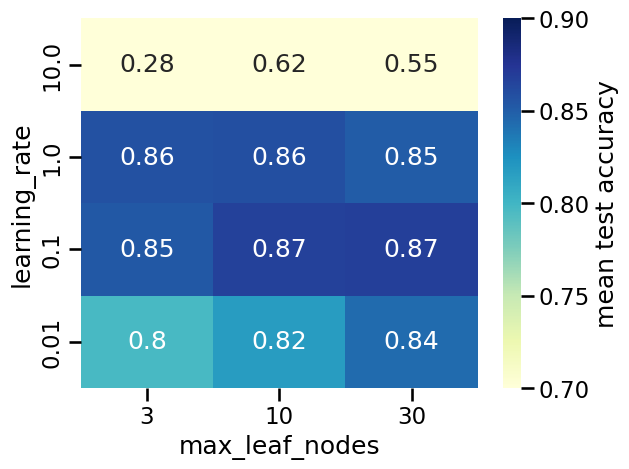

In [21]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results,
    annot=True,
    cmap="YlGnBu",
    vmin=0.7,
    vmax=0.9,
    cbar_kws={"label": "mean test accuracy"},
)
ax.invert_yaxis()

The above tables highlights the following things:

* for too high values of `learning_rate`, the generalization performance of
  the model is degraded and adjusting the value of `max_leaf_nodes` cannot fix
  that problem;
* outside of this pathological region, we observe that the optimal choice of
  `max_leaf_nodes` depends on the value of `learning_rate`;
* in particular, we observe a "diagonal" of good models with an accuracy close
  to the maximal of 0.87: when the value of `max_leaf_nodes` is increased, one
  should decrease the value of `learning_rate` accordingly to preserve a good
  accuracy.

The precise meaning of those two parameters will be explained later.

For now we note that, in general, **there is no unique optimal parameter
setting**: 4 models out of the 12 parameter configurations reach the maximal
accuracy (up to small random fluctuations caused by the sampling of the
training set).

In this notebook we have seen:

* how to optimize the hyperparameters of a predictive model via a grid-search;
* that searching for more than two hyperparamters is too costly;
* that a grid-search does not necessarily find an optimal solution.